In [1]:
%pip install albumentations datasets > /dev/null

In [2]:
# Import necessary libraries
import os
import sys
import gzip
import struct
from typing import List

import albumentations as albu  # Library for image augmentation
import cv2  # OpenCV library for image processing
import numpy as np
from tqdm import tqdm  # Library for progress bars

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader  # PyTorch utilities for data handling
import torchvision.models as models  # Pre-trained models provided by PyTorch

from datasets import load_dataset  # Custom function to load dataset

import matplotlib.pyplot as plt  # Library for plotting graphs and images

In [3]:
torch.manual_seed(42)  # Set random seed for reproducibility

## Dataset - [Tiny ImageNet](https://huggingface.co/datasets/zh-plus/tiny-imagenet)


In [4]:
# Load the dataset using the load_dataset function with parameters "frgfm/imagenette" and "320px".
# The "frgfm/imagenette" dataset is being loaded with images resized to 320 pixels.
dataset = load_dataset("frgfm/imagenette", "320px")

# Define the number of labels in the dataset.
num_labels = 10

# Print the dataset object.
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

imagenette.py:   0%|          | 0.00/5.31k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

In [5]:
# Access the training split of the dataset using the key "train".
# Then, access the 124th sample (indexing is 0-based) within the training split.
# Retrieve the image data associated with the sample.
image_data = dataset["train"][123]["image"]

In [6]:
class HuggingFaceDataset(Dataset):
    """
    Define a custom dataset class named HuggingFaceDataset inheriting from the PyTorch Dataset class.
    """
    def __init__(self, dataset: Dataset, augmentations: albu.Compose) -> None:
        # Constructor method to initialize the dataset and augmentation transformations.
        self.dataset = dataset  # Store the input dataset
        self.augs = augmentations  # Store the augmentation transformations

    def __len__(self) -> int:
        # Override the len method to return the length of the dataset.
        return len(self.dataset)

    def __getitem__(self, index) -> tuple:
        # Override the getitem method to retrieve a sample from the dataset.
        sample = self.dataset[index]  # Get the sample at the specified index from the dataset

        # Convert the image to RGB format if it's not already in that format
        image = sample["image"].convert("RGB")

        # Apply the specified augmentations to the image
        image = self.augs(image=np.array(image))["image"]

        # Convert the augmented image to a PyTorch tensor and permute its dimensions
        image = torch.from_numpy(image).permute(2, 0, 1)

        # Convert the label to a PyTorch LongTensor
        label = torch.LongTensor([sample["label"]])

        # Return the augmented image and its corresponding label as a tuple
        return image, label


In [7]:
# Set the batch size for training
batch_size = 32

# Define the input shape for the images (height, width).
# NOTE: To speed up training, you can decrease the input shape, but it may affect the final performance.
input_shape = (224, 224)

# Set the number of workers for data loading to be the number of available CPU cores
workers = os.cpu_count()

# Define the augmentation transformations for training images
# TODO: optional, play with augmentations
train_augs = albu.Compose([
    albu.Resize(input_shape[0], input_shape[1]),
    albu.HorizontalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.2),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Create a DataLoader for training data using the defined augmentations
train_loader = DataLoader(
    HuggingFaceDataset(dataset['train'], train_augs),
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

# Define the augmentation transformations for validation images
valid_augs = albu.Compose([
    albu.Resize(input_shape[0], input_shape[1]),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Create a DataLoader for validation data using the defined augmentations
valid_loader = DataLoader(
    HuggingFaceDataset(dataset['validation'], valid_augs),
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers
)


In [8]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    """
    Function to train the model for one epoch.

    Args:
    - model: The neural network model to be trained.
    - loader: DataLoader object for loading the training data.
    - criterion: Loss function criterion.
    - optimizer: Optimizer for updating model parameters.
    - device: Device to run the model on (default is "cpu").
    - verbose: If True, print progress during training.

    Returns:
    - logs: Dictionary containing training statistics.
    """
    # TODO: complete training function
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    logs = {
        "loss": running_loss / len(loader),
        "accuracy": correct / total,
    }
    if verbose:
        print(f"Train Loss: {logs['loss']:.4f}, Train Accuracy: {logs['accuracy']:.4f}")
    return logs

In [9]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    """
    Function to evaluate the model on the validation or test set.

    Args:
    - model: The neural network model to be evaluated.
    - loader: DataLoader object for loading the validation or test data.
    - criterion: Loss function criterion.
    - device: Device to run the model on (default is "cpu").
    - verbose: If True, print evaluation results.

    Returns:
    - logs: Dictionary containing evaluation statistics.
    """
    # TODO: complete evaluation function
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device).squeeze()

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    logs = {
        "eval_loss": running_loss / len(loader),
        "accuracy": correct / total,
    }
    if verbose:
        print(f"Validation Loss: {logs['eval_loss']:.4f}, Validation Accuracy: {logs['accuracy']:.4f}")
    return logs

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 168MB/s]



Epoch  1/20


Train Loss: 0.6220, Train Accuracy: 0.8104
      Train loss: 0.6220164001491424
  Train accuracy: 0.8104340479459288


Validation Loss: 0.7332, Validation Accuracy: 0.7623
Validation loss: 0.7332494567125672
Validation accuracy: 0.7622929936305732

Epoch  2/20


Train Loss: 0.4174, Train Accuracy: 0.8718
      Train loss: 0.41742671812204896
  Train accuracy: 0.8717921639032633


Validation Loss: 0.4866, Validation Accuracy: 0.8527
Validation loss: 0.48663485185546057
Validation accuracy: 0.8527388535031847

Epoch  3/20


Train Loss: 0.3463, Train Accuracy: 0.8909
      Train loss: 0.34633349362332877
  Train accuracy: 0.8909071707677685


Validation Loss: 0.6432, Validation Accuracy: 0.7990
Validation loss: 0.643227845157792
Validation accuracy: 0.7989808917197452

Epoch  4/20


Train Loss: 0.2720, Train Accuracy: 0.9149
      Train loss: 0.2720264174182572
  Train accuracy: 0.9148801351779491


Validation Loss: 0.4295, Validation Accuracy: 0.8741
Validation loss: 0.42954341799013196
Validation accuracy: 0.8741401273885351

Epoch  5/20


Train Loss: 0.2450, Train Accuracy: 0.9220
      Train loss: 0.2449823196952206
  Train accuracy: 0.921955855950998


Validation Loss: 0.4155, Validation Accuracy: 0.8744
Validation loss: 0.41553710841354197
Validation accuracy: 0.8743949044585987

Epoch  6/20


Train Loss: 0.1834, Train Accuracy: 0.9445
      Train loss: 0.18339305109898182
  Train accuracy: 0.9444503115429296


Validation Loss: 0.4218, Validation Accuracy: 0.8739
Validation loss: 0.42175966665542464
Validation accuracy: 0.8738853503184714

Epoch  7/20


Train Loss: 0.2088, Train Accuracy: 0.9335
      Train loss: 0.20876948709750698
  Train accuracy: 0.933467103178794


Validation Loss: 0.3933, Validation Accuracy: 0.8780
Validation loss: 0.39333964819164297
Validation accuracy: 0.8779617834394905

Epoch  8/20


Train Loss: 0.1262, Train Accuracy: 0.9603
      Train loss: 0.12623720822975393
  Train accuracy: 0.9602914774527406


Validation Loss: 0.4010, Validation Accuracy: 0.8915
Validation loss: 0.4010239023624397
Validation accuracy: 0.8914649681528662

Epoch  9/20


Train Loss: 0.1338, Train Accuracy: 0.9565
      Train loss: 0.13382888759165448
  Train accuracy: 0.9564895976343859


Validation Loss: 0.4904, Validation Accuracy: 0.8734
Validation loss: 0.4904043262377684
Validation accuracy: 0.8733757961783439

Epoch 10/20


Train Loss: 0.1548, Train Accuracy: 0.9511
      Train loss: 0.1547949205316301
  Train accuracy: 0.9511036012250501


Validation Loss: 0.4635, Validation Accuracy: 0.8792
Validation loss: 0.4634527724195552
Validation accuracy: 0.879235668789809

Epoch 11/20


Train Loss: 0.1068, Train Accuracy: 0.9641
      Train loss: 0.10675304069740672
  Train accuracy: 0.9640933572710951


Validation Loss: 0.4517, Validation Accuracy: 0.8831
Validation loss: 0.45172669067746973
Validation accuracy: 0.8830573248407644

Epoch 12/20


Train Loss: 0.1117, Train Accuracy: 0.9664
      Train loss: 0.11172192890709895
  Train accuracy: 0.9664167282712007


Validation Loss: 0.4629, Validation Accuracy: 0.8823
Validation loss: 0.462881298593413
Validation accuracy: 0.8822929936305732

Epoch 13/20


Train Loss: 0.1000, Train Accuracy: 0.9685
      Train loss: 0.09996990821476888
  Train accuracy: 0.9685288837258422


Validation Loss: 0.5011, Validation Accuracy: 0.8693
Validation loss: 0.501079620369445
Validation accuracy: 0.8692993630573248

Epoch 14/20


Train Loss: 0.0992, Train Accuracy: 0.9686
      Train loss: 0.09923368897658735
  Train accuracy: 0.9686344914985743


Validation Loss: 0.5787, Validation Accuracy: 0.8655
Validation loss: 0.578711701405369
Validation accuracy: 0.8654777070063694

Epoch 15/20


Train Loss: 0.0829, Train Accuracy: 0.9744
      Train loss: 0.08289650452757455
  Train accuracy: 0.9744429189988383


Validation Loss: 0.4915, Validation Accuracy: 0.8757
Validation loss: 0.49148312369179326
Validation accuracy: 0.8756687898089172

Epoch 16/20


Train Loss: 0.1075, Train Accuracy: 0.9655
      Train loss: 0.10746971383589364
  Train accuracy: 0.9654662583166121


Validation Loss: 0.4425, Validation Accuracy: 0.8876
Validation loss: 0.4424712337421942
Validation accuracy: 0.8876433121019108

Epoch 17/20


Train Loss: 0.0703, Train Accuracy: 0.9770
      Train loss: 0.070292271909853
  Train accuracy: 0.9769775055444081


Validation Loss: 0.4032, Validation Accuracy: 0.9004
Validation loss: 0.4032080280187547
Validation accuracy: 0.9003821656050955

Epoch 18/20


Train Loss: 0.0477, Train Accuracy: 0.9846
      Train loss: 0.04765525244589741
  Train accuracy: 0.9845812651811173


Validation Loss: 0.4063, Validation Accuracy: 0.9055
Validation loss: 0.4062945637717082
Validation accuracy: 0.9054777070063694

Epoch 19/20


Train Loss: 0.0977, Train Accuracy: 0.9699
      Train loss: 0.09771764510028211
  Train accuracy: 0.9699017847713591


Validation Loss: 0.6236, Validation Accuracy: 0.8673
Validation loss: 0.6235955015650185
Validation accuracy: 0.8672611464968153

Epoch 20/20


Train Loss: 0.0781, Train Accuracy: 0.9743
      Train loss: 0.07808230796512657
  Train accuracy: 0.9743373112261062


Validation Loss: 0.4079, Validation Accuracy: 0.8938
Validation loss: 0.40793011629408815
Validation accuracy: 0.8937579617834395


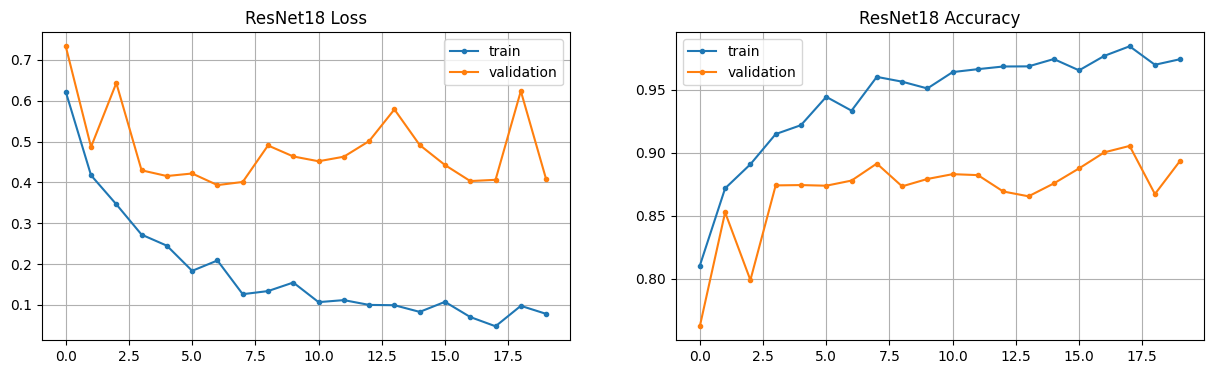


Epoch  1/20


Train Loss: 0.7810, Train Accuracy: 0.7582
      Train loss: 0.7810105928597418
  Train accuracy: 0.7581582004435526


Validation Loss: 0.9966, Validation Accuracy: 0.7121
Validation loss: 0.9966063065363503
Validation accuracy: 0.7121019108280254

Epoch  2/20


Train Loss: 0.4969, Train Accuracy: 0.8438
      Train loss: 0.4969296881526306
  Train accuracy: 0.8438061041292639


Validation Loss: 0.5111, Validation Accuracy: 0.8405
Validation loss: 0.5111161933197239
Validation accuracy: 0.8405095541401274

Epoch  3/20


Train Loss: 0.3902, Train Accuracy: 0.8784
      Train loss: 0.3901624242598946
  Train accuracy: 0.8784454535853838


Validation Loss: 0.5079, Validation Accuracy: 0.8428
Validation loss: 0.5078956076678464
Validation accuracy: 0.8428025477707006

Epoch  4/20


Train Loss: 0.3069, Train Accuracy: 0.9062
      Train loss: 0.30690021822984154
  Train accuracy: 0.9062202978139191


Validation Loss: 0.4192, Validation Accuracy: 0.8680
Validation loss: 0.419156061561127
Validation accuracy: 0.8680254777070063

Epoch  5/20


Train Loss: 0.2991, Train Accuracy: 0.9048
      Train loss: 0.2991300726724738
  Train accuracy: 0.9048473967684022


Validation Loss: 0.4792, Validation Accuracy: 0.8571
Validation loss: 0.4791882211584749
Validation accuracy: 0.8570700636942675

Epoch  6/20


Train Loss: 0.2213, Train Accuracy: 0.9310
      Train loss: 0.22129055955195548
  Train accuracy: 0.9310381244059562


Validation Loss: 0.3412, Validation Accuracy: 0.8945
Validation loss: 0.3412391450710413
Validation accuracy: 0.8945222929936306

Epoch  7/20


Train Loss: 0.2008, Train Accuracy: 0.9361
      Train loss: 0.20075110672513727
  Train accuracy: 0.9361072974970958


Validation Loss: 0.4283, Validation Accuracy: 0.8813
Validation loss: 0.4283277549921929
Validation accuracy: 0.8812738853503185

Epoch  8/20


Train Loss: 0.1740, Train Accuracy: 0.9449
      Train loss: 0.17402248917701277
  Train accuracy: 0.9448727426338579


Validation Loss: 0.3997, Validation Accuracy: 0.8876
Validation loss: 0.39968211512740065
Validation accuracy: 0.8876433121019108

Epoch  9/20


Train Loss: 0.1610, Train Accuracy: 0.9471
      Train loss: 0.16103297042521975
  Train accuracy: 0.9470905058612313


Validation Loss: 0.3313, Validation Accuracy: 0.8989
Validation loss: 0.33125353204767877
Validation accuracy: 0.8988535031847134

Epoch 10/20


Train Loss: 0.1456, Train Accuracy: 0.9498
      Train loss: 0.14556186340711508
  Train accuracy: 0.9498363079522653


Validation Loss: 0.4761, Validation Accuracy: 0.8711
Validation loss: 0.47608285922041527
Validation accuracy: 0.8710828025477707

Epoch 11/20


Train Loss: 0.1397, Train Accuracy: 0.9546
      Train loss: 0.139696843544575
  Train accuracy: 0.9545886577252086


Validation Loss: 0.3790, Validation Accuracy: 0.8882
Validation loss: 0.37904261208586093
Validation accuracy: 0.8881528662420383

Epoch 12/20


Train Loss: 0.1094, Train Accuracy: 0.9646
      Train loss: 0.10939090430887567
  Train accuracy: 0.9646213961347555


Validation Loss: 0.4773, Validation Accuracy: 0.8790
Validation loss: 0.47731410385286593
Validation accuracy: 0.8789808917197452

Epoch 13/20


Train Loss: 0.1071, Train Accuracy: 0.9653
      Train loss: 0.10709736695571337
  Train accuracy: 0.9652550427711479


Validation Loss: 0.4810, Validation Accuracy: 0.8754
Validation loss: 0.48101737384298227
Validation accuracy: 0.8754140127388536

Epoch 14/20


Train Loss: 0.1024, Train Accuracy: 0.9695
      Train loss: 0.10241045770424141
  Train accuracy: 0.9694793536804309


Validation Loss: 0.3837, Validation Accuracy: 0.8884
Validation loss: 0.3837240847221356
Validation accuracy: 0.8884076433121019

Epoch 15/20


Train Loss: 0.0769, Train Accuracy: 0.9775
      Train loss: 0.07694578701754122
  Train accuracy: 0.9775055444080685


Validation Loss: 0.4456, Validation Accuracy: 0.8797
Validation loss: 0.4455996361027313
Validation accuracy: 0.8797452229299363

Epoch 16/20


Train Loss: 0.1013, Train Accuracy: 0.9661
      Train loss: 0.10133048282020625
  Train accuracy: 0.9660999049530046


Validation Loss: 0.4993, Validation Accuracy: 0.8657
Validation loss: 0.49929463796741597
Validation accuracy: 0.8657324840764331

Epoch 17/20


Train Loss: 0.0781, Train Accuracy: 0.9747
      Train loss: 0.07813718268103863
  Train accuracy: 0.9746541345443025


Validation Loss: 0.4239, Validation Accuracy: 0.8915
Validation loss: 0.42392707626691195
Validation accuracy: 0.8914649681528662

Epoch 18/20


Train Loss: 0.0680, Train Accuracy: 0.9768
      Train loss: 0.068026322419354
  Train accuracy: 0.9767662899989439


Validation Loss: 0.5075, Validation Accuracy: 0.8767
Validation loss: 0.5075248012970376
Validation accuracy: 0.876687898089172

Epoch 19/20


Train Loss: 0.0797, Train Accuracy: 0.9764
      Train loss: 0.07970830627537735
  Train accuracy: 0.9764494666807477


Validation Loss: 0.5229, Validation Accuracy: 0.8611
Validation loss: 0.5228561518971271
Validation accuracy: 0.8611464968152867

Epoch 20/20


Train Loss: 0.0688, Train Accuracy: 0.9775
      Train loss: 0.06877105779720885
  Train accuracy: 0.9775055444080685


Validation Loss: 0.6015, Validation Accuracy: 0.8639
Validation loss: 0.6015164790146442
Validation accuracy: 0.8639490445859873


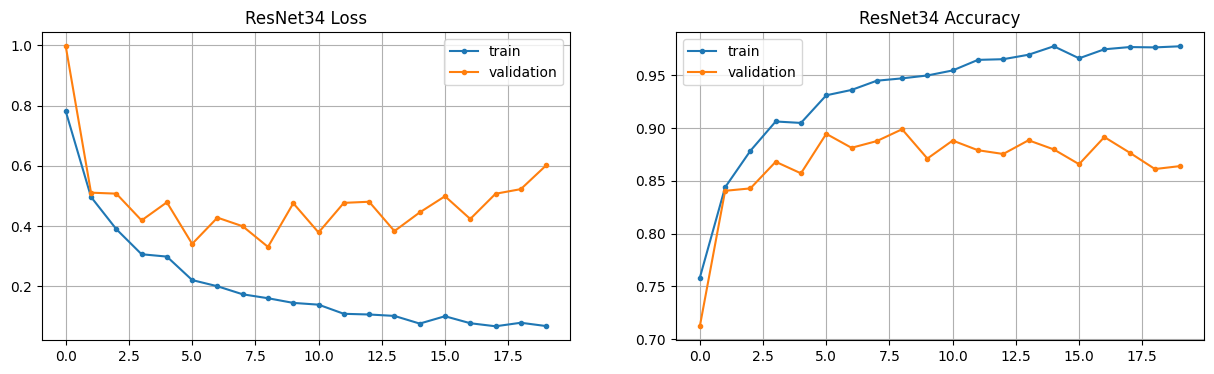


Epoch  1/20


Train Loss: 0.3605, Train Accuracy: 0.8994
      Train loss: 0.36048056010307894
  Train accuracy: 0.8993557925863344


Validation Loss: 0.1791, Validation Accuracy: 0.9488
Validation loss: 0.17913191660388508
Validation accuracy: 0.9487898089171974

Epoch  2/20


Train Loss: 0.1934, Train Accuracy: 0.9429
      Train loss: 0.19335646325458042
  Train accuracy: 0.9428661949519485


Validation Loss: 0.3097, Validation Accuracy: 0.8973
Validation loss: 0.30968760942512125
Validation accuracy: 0.8973248407643312

Epoch  3/20


Train Loss: 0.1407, Train Accuracy: 0.9559
      Train loss: 0.1406756788539398
  Train accuracy: 0.9558559509979935


Validation Loss: 0.1490, Validation Accuracy: 0.9513
Validation loss: 0.14898173734962153
Validation accuracy: 0.9513375796178344

Epoch  4/20


Train Loss: 0.1277, Train Accuracy: 0.9613
      Train loss: 0.12768017373604676
  Train accuracy: 0.9613475551800612


Validation Loss: 0.1787, Validation Accuracy: 0.9429
Validation loss: 0.1787068157908043
Validation accuracy: 0.9429299363057325

Epoch  5/20


Train Loss: 0.1131, Train Accuracy: 0.9634
      Train loss: 0.11305037114613475
  Train accuracy: 0.9633541028619707


Validation Loss: 0.2669, Validation Accuracy: 0.9297
Validation loss: 0.2669094392989333
Validation accuracy: 0.9296815286624204

Epoch  6/20


Train Loss: 0.0881, Train Accuracy: 0.9742
      Train loss: 0.0881099370500935
  Train accuracy: 0.9742317034533742


Validation Loss: 0.2472, Validation Accuracy: 0.9350
Validation loss: 0.2472020748754721
Validation accuracy: 0.935031847133758

Epoch  7/20


Train Loss: 0.0919, Train Accuracy: 0.9696
      Train loss: 0.09194958383552541
  Train accuracy: 0.969584961453163


Validation Loss: 0.2144, Validation Accuracy: 0.9394
Validation loss: 0.2143724620310548
Validation accuracy: 0.9393630573248407

Epoch  8/20


Train Loss: 0.0887, Train Accuracy: 0.9714
      Train loss: 0.08870476689244734
  Train accuracy: 0.9713802935896082


Validation Loss: 0.2065, Validation Accuracy: 0.9406
Validation loss: 0.20650735936130712
Validation accuracy: 0.9406369426751592

Epoch  9/20


Train Loss: 0.0804, Train Accuracy: 0.9740
      Train loss: 0.08036947474387046
  Train accuracy: 0.9740204879079101


Validation Loss: 0.2040, Validation Accuracy: 0.9437
Validation loss: 0.20401943045241447
Validation accuracy: 0.9436942675159236

Epoch 10/20


Train Loss: 0.0634, Train Accuracy: 0.9798
      Train loss: 0.06336939482423838
  Train accuracy: 0.9798289154081741


Validation Loss: 0.1729, Validation Accuracy: 0.9534
Validation loss: 0.17292436586506565
Validation accuracy: 0.953375796178344

Epoch 11/20


Train Loss: 0.0571, Train Accuracy: 0.9818
      Train loss: 0.05710253349128391
  Train accuracy: 0.9818354630900834


Validation Loss: 0.2420, Validation Accuracy: 0.9378
Validation loss: 0.2419899621057905
Validation accuracy: 0.9378343949044586

Epoch 12/20


Train Loss: 0.0634, Train Accuracy: 0.9790
      Train loss: 0.06343300283274525
  Train accuracy: 0.9789840532263174


Validation Loss: 0.1919, Validation Accuracy: 0.9478
Validation loss: 0.1918727029059057
Validation accuracy: 0.9477707006369427

Epoch 13/20


Train Loss: 0.0535, Train Accuracy: 0.9843
      Train loss: 0.05354162876952811
  Train accuracy: 0.9842644418629211


Validation Loss: 0.2322, Validation Accuracy: 0.9404
Validation loss: 0.23220562405206477
Validation accuracy: 0.9403821656050956

Epoch 14/20


Train Loss: 0.0644, Train Accuracy: 0.9799
      Train loss: 0.06439367949831255
  Train accuracy: 0.9799345231809061


Validation Loss: 0.1748, Validation Accuracy: 0.9516
Validation loss: 0.17478138046448943
Validation accuracy: 0.9515923566878981

Epoch 15/20


Train Loss: 0.0520, Train Accuracy: 0.9850
      Train loss: 0.05200540428169818
  Train accuracy: 0.9850036962720456


Validation Loss: 0.2088, Validation Accuracy: 0.9457
Validation loss: 0.20883062138149605
Validation accuracy: 0.9457324840764331

Epoch 16/20


Train Loss: 0.0530, Train Accuracy: 0.9815
      Train loss: 0.053003468311421664
  Train accuracy: 0.9815186397718872


Validation Loss: 0.2221, Validation Accuracy: 0.9447
Validation loss: 0.22209329241560888
Validation accuracy: 0.9447133757961783

Epoch 17/20


Train Loss: 0.0715, Train Accuracy: 0.9767
      Train loss: 0.07147136016420838
  Train accuracy: 0.9766606822262118


Validation Loss: 0.2184, Validation Accuracy: 0.9455
Validation loss: 0.2183864998740511
Validation accuracy: 0.9454777070063695

Epoch 18/20


Train Loss: 0.0396, Train Accuracy: 0.9881
      Train loss: 0.03963599933834032
  Train accuracy: 0.9880663216812757


Validation Loss: 0.2217, Validation Accuracy: 0.9376
Validation loss: 0.22169816775070147
Validation accuracy: 0.9375796178343949

Epoch 19/20


Train Loss: 0.0586, Train Accuracy: 0.9817
      Train loss: 0.05855263998244088
  Train accuracy: 0.9817298553173514


Validation Loss: 0.2174, Validation Accuracy: 0.9422
Validation loss: 0.21741423855426192
Validation accuracy: 0.9421656050955414

Epoch 20/20


Train Loss: 0.0450, Train Accuracy: 0.9861
      Train loss: 0.04501049323187397
  Train accuracy: 0.9860597739993664


Validation Loss: 0.2025, Validation Accuracy: 0.9457
Validation loss: 0.20247245623362303
Validation accuracy: 0.9457324840764331


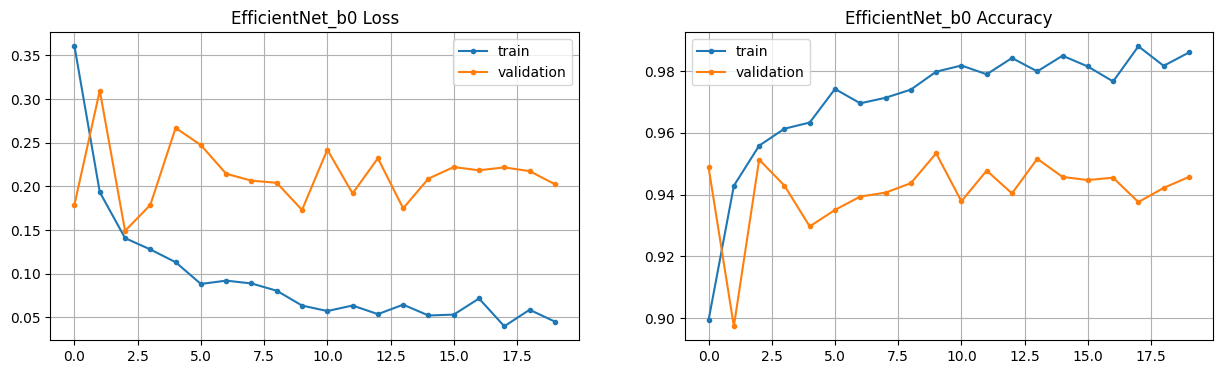

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

models_to_try = [
    (models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1), "ResNet18"),
    (models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1), "ResNet34"),
    (models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1), "EfficientNet_b0")
]

results = {}

for model, name in models_to_try:
    if isinstance(model, models.EfficientNet):
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_labels)
    else:
        model.fc = nn.Linear(model.fc.in_features, num_labels)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    n_epochs = 20
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    best_acc = 0.0
    for ep in range(n_epochs):
        print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")
        train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        train_losses.append(train_logs["loss"])
        train_accuracies.append(train_logs["accuracy"])
        print("      Train loss:", train_losses[-1])
        print("  Train accuracy:", train_accuracies[-1])

        valid_logs = evaluate(model, valid_loader, loss_fn, device)
        valid_losses.append(valid_logs["eval_loss"])
        valid_accuracies.append(valid_logs["accuracy"])
        print("Validation loss:", valid_losses[-1])
        print("Validation accuracy:", valid_accuracies[-1])

        if valid_logs["accuracy"] > best_acc:
            best_acc = valid_logs["accuracy"]

    results[name] = best_acc

    # Візуалізація
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
    axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
    axes[0].legend(["train", "validation"])
    axes[0].set_title(f"{name} Loss")
    axes[0].grid()

    axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
    axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
    axes[1].legend(["train", "validation"])
    axes[1].set_title(f"{name} Accuracy")
    axes[1].grid()
    plt.show()

In [12]:
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")
print("The best model:", max(results, key=results.get))

ResNet18: 0.9055
ResNet34: 0.8989
EfficientNet_b0: 0.9534
The best model: EfficientNet_b0
